In [1]:
# TODO: replace df with dataframe
# TODO: investigate presence of multiple 'Plate ID' columns in condition_summary
# TODO: add dataset selector (or make new notebooks for analyzing different datasets - this might be better, think about it.)

In [2]:
execfile('./src/display_utils.py')
execfile('./src/moldev_utils.py')
%matplotlib inline

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
cell_path = '../moldev-data/analyzed/06-19-2015/ssC.csv'
well_path = '../moldev-data/analyzed/06-19-2015/ssC-wells.csv'
condition_path = '../moldev-data/analyzed/06-19-2015/ssC-conditions.csv'

colors = {'Blue & Red':'bwr','Blue':'Blues'}

In [4]:
well_data = pd.read_csv(well_path)

condition_data = pd.read_csv(condition_path)

raw_cell_data = pd.read_csv(cell_path)
# cell_data = add_condition_cols(raw_cell_data)

---
# Well Plate Results

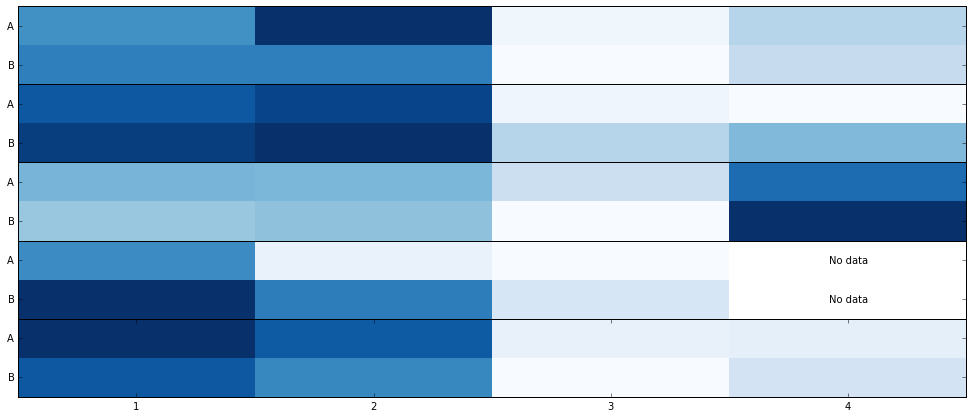

In [5]:

interact(plot_plates, 
         dataframe = fixed(well_data),
         parameter = widgets.Select(value = 'Cell Count',
                                    options= get_params(well_data),
                                    height=250),
         function = well_data['Function'].unique().tolist(),
         color = colors,
         show = widgets.ToggleButtons(options=['None','Values','Conditions']));

---
# How do conditions cluster together?

In [6]:
data = pipe(condition_data,
            get_means,
            lambda x: x.set_index('Condition'),
            normalize_columns,
            lambda x: x.dropna(axis=1,how='all'))

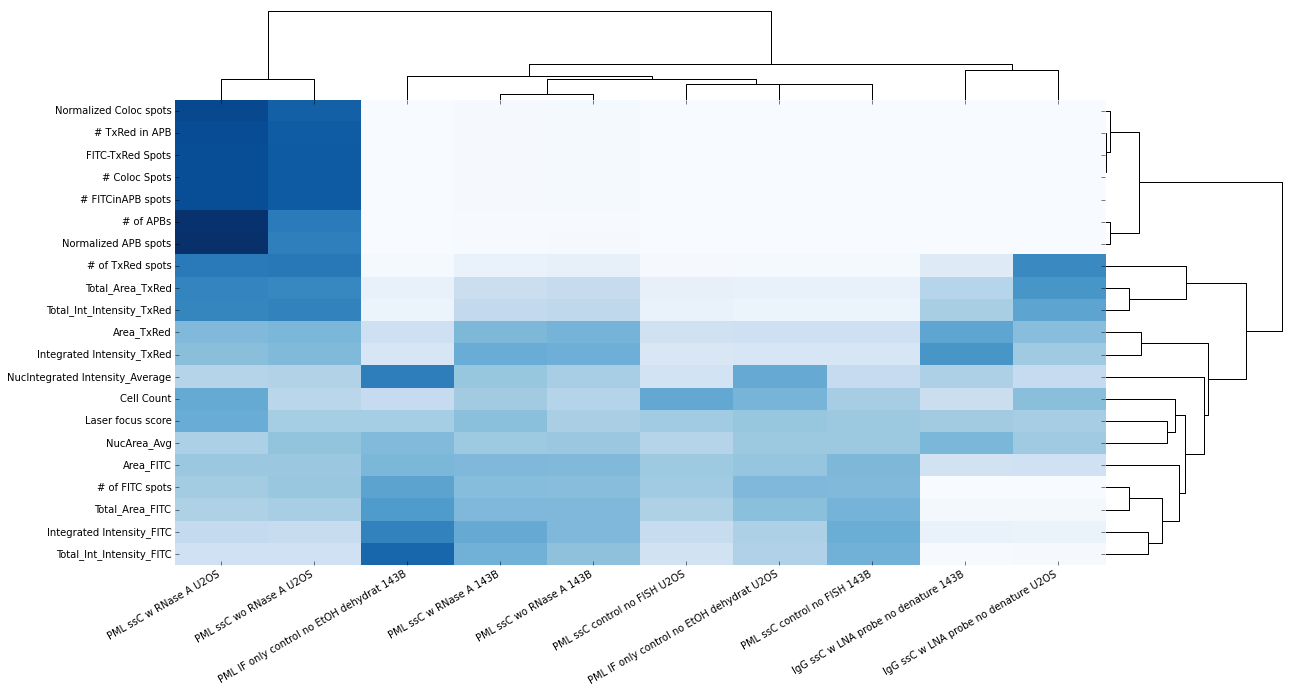

In [7]:
interact(matrix_tree, data = fixed(data), color = colors);

---
# Heatmap subsets

In [8]:
def wrapper(conditions,features,color):
    df = data.loc[list(conditions)][list(features)]
    try: 
        matrix_tree(df,color)
    except:
        print "\n".join(["-"*50, "Please select multiple features and conditions.","-"*50])

subset = interactive(wrapper,
                     conditions = widgets.SelectMultiple(options = data.index.values.tolist(),height = 300),
                     features = widgets.SelectMultiple(options = data.columns.values.tolist(),height = 300),
                     color = colors)
subset

--------------------------------------------------
Please select multiple features and conditions.
--------------------------------------------------


# Which parameters don't have any data? 

In [9]:
for col in sorted(set(condition_data.columns).difference(data.columns)):
    if col not in ['Condition','Function']: print col

Area_APB
Area_Coloc_Avg
Area_FITCinAPB_Avg
Area_FITCinAPB_Total
Area_TxRedinAPB_Avg
Area_TxRedinAPB_Total
FITC-TxRed_Area_Avg
FITC-TxRed_Area_Total
FITCinAPB_Int_Intensity_Avg
FITCinAPB_Int_Intensity_Total
Normalized Coloc area
Total_Area_Coloc
TxRedinAPB_Int_Intensity_Avg
TxRinAPB_Int_Intensity_Total


---
# How do parameters vary with drug dose?

In [11]:
# dose_data = thread_first(condition_data,
#                         lambda df: df[df['Function'] == 'avg'],
#                         add_condition_cols)

# dose_error = thread_first(condition_data,
#                         lambda df: df[df['Function'] == 'sem'],
#                         add_condition_cols)

In [12]:
# interact(dose_plot,
#          scale = widgets.ToggleButtons(options=['linear','log']), 
#          df = fixed(dose_data),
#          err = fixed(dose_error),
#          cols = widgets.SelectMultiple(value = ['Cell Count'],
#                               options= [col for col in dose_data.columns.values.tolist() if col not in ['Condition','Function','Base','Dose','Unit','Drug']],
#                               height=250));

---
#How are different parameters related?

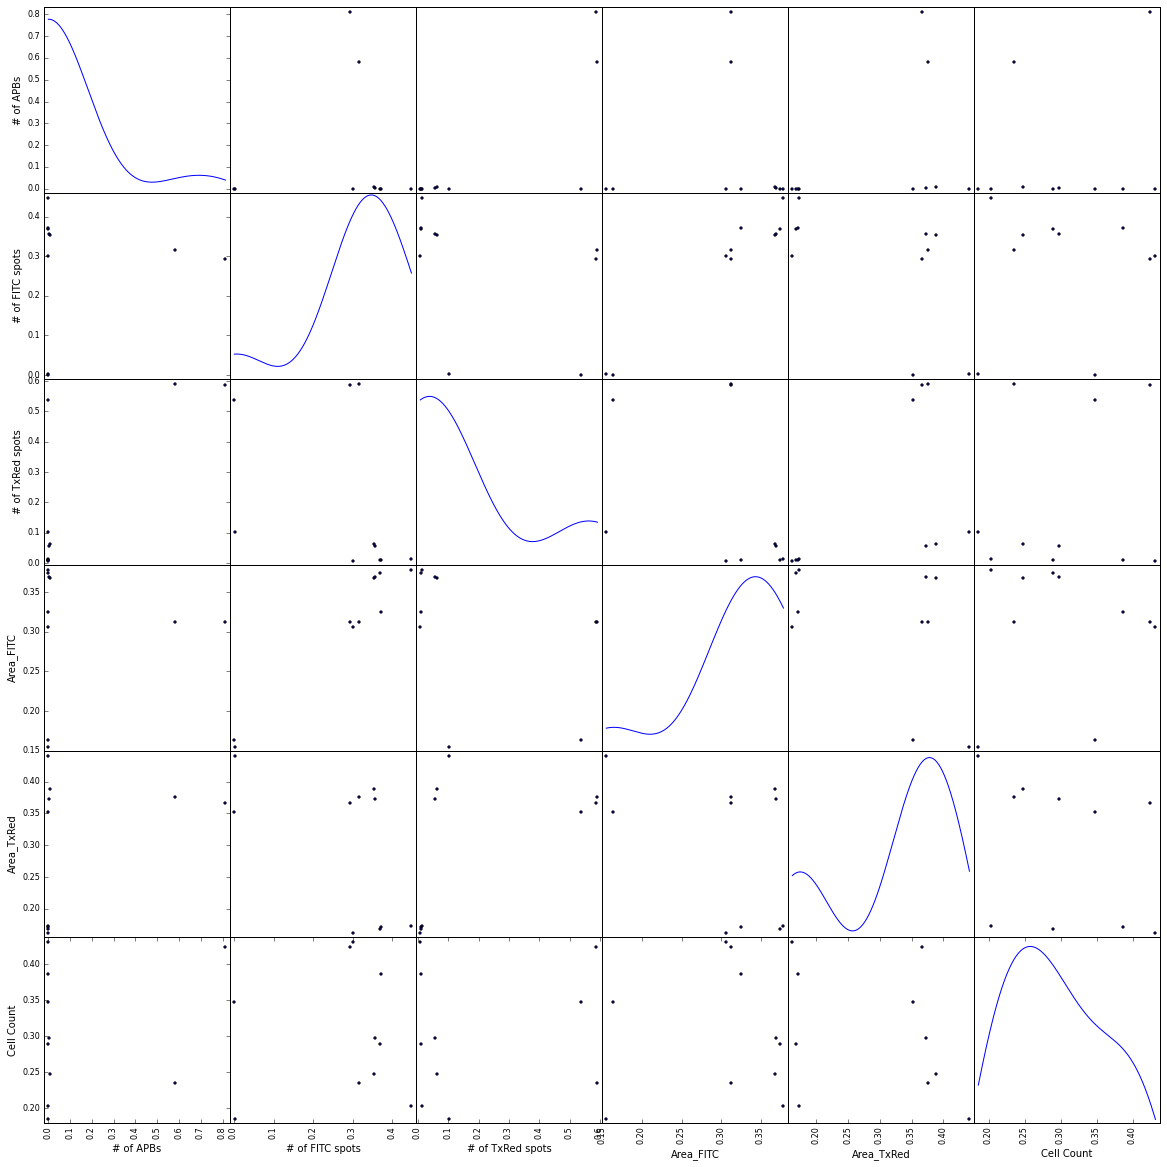

In [14]:
from pandas.tools.plotting import scatter_matrix

def scatter(df,cols):
    scatter_matrix(data[list(cols)], alpha=1, figsize=(20, 20), diagonal='kde');
    
interact(scatter, 
         df = fixed(data),
         cols = widgets.SelectMultiple(value = ['Cell Count'],
                              options= get_params(data),
                              height=250));

---
# Parameter vs. Conditions

In [57]:
def plot_dist(data,parameter):        
    fig = plt.figure(num=None, figsize=(15, 7), dpi=100, facecolor='w', edgecolor='k')
#     sns.boxplot(data[parameter], 
#                 data['Condition'],
#                 vert=True,
#                 order=sorted(data.Condition.unique()),
#                 color = 'w')
#     sns.boxplot(x = parameter, 
#                 y = 'Condition',
#                 data = data,
#                 vert=True,
#                 order=sorted(data.Condition.unique()),
#                 color = 'k')
    sns.boxplot(x = 'Condition',
                y = parameter, 
                data = data,
                color = 'w',
                order = sorted(data.Condition.unique()))    
    
    plt.ylabel(parameter,fontsize=20)
    plt.xlabel('Condition',fontsize=20)
    plt.title('Distribution: ' + parameter,fontsize=20)
    plt.tick_params(labelsize=10)
    plt.xticks(rotation=30,ha='right')
    mean = data[parameter].mean()
    plt.gca().set_ylim(bottom=data[parameter].mean() * -0.5)

In [58]:
def dist_wrapper(parameter):
    if parameter == 'Cell Count':
        dataframe = filter_rows(well_data,'Function','avg')
    else: 
        dataframe = raw_cell_data
    plot_dist(dataframe,parameter)

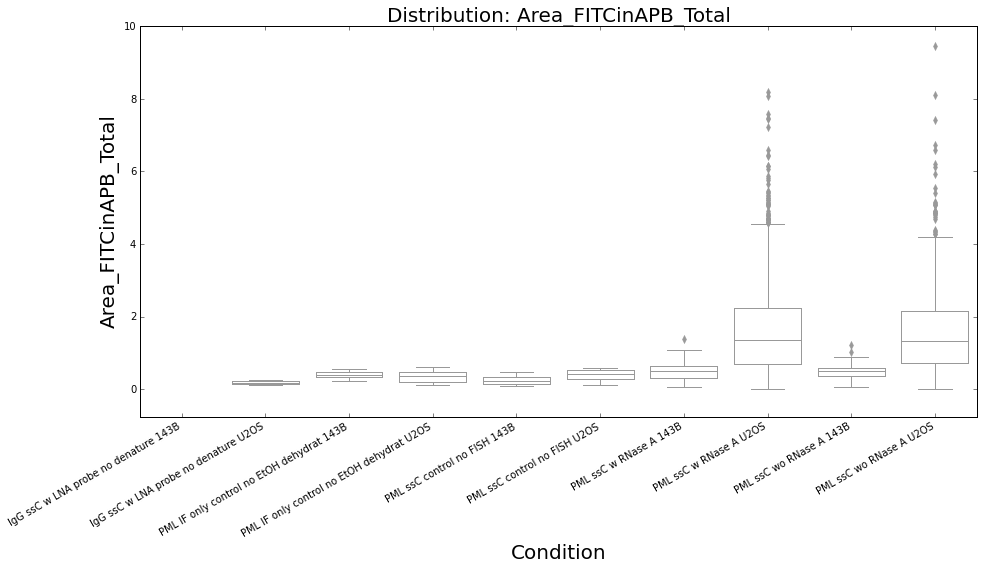

In [59]:
interactive(dist_wrapper,
            parameter = get_params(raw_cell_data) + ['Cell Count'])

---
# Compare conditions

In [60]:
def compare_condition_dists(df, conditions, parameters, bandwidth=0.1, shaded = True, clip_ends = False, scale='linear'):
    n_rows = int(np.ceil(len(parameters)/3.0))
    plt.figure(figsize=(20,4 * n_rows))
    subs = gridspec.GridSpec(n_rows, 3) 
    plt.subplots_adjust(hspace=0.54,wspace=0.27)

    for parameter,sub in zip(parameters,subs):
        plt.subplot(sub)
        param_bandwidth = bandwidth * df[df.Condition == conditions[0]][parameter].mean()
        for condition in conditions:
            data = df[df.Condition == condition][parameter]
            kws = {"shade": shaded, "bw": param_bandwidth}
            if clip_ends: 
                kws = assoc(kws,"cut",0)
            sns.distplot(data, hist=False, kde_kws=kws,label=condition)
            plt.legend(loc = 0)
        if scale is not 'linear':
            plt.xscale('log')
        plt.ylabel('Frequency')

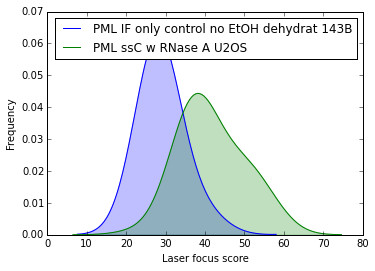

In [63]:
interact(compare_condition_dists,
         df = fixed(raw_cell_data),
         conditions = widgets.SelectMultiple(options = raw_cell_data.Condition.unique().tolist(),height = 300),
         parameters = widgets.SelectMultiple(options = get_params(raw_cell_data),height = 300),
         bandwidth = (0,0.2,0.01),
         scale = widgets.ToggleButtons(options=['linear','log']));

---
# Compare parameters

In [65]:
def compare_parameter_dists(df, conditions, parameters, bandwidth=0.1, shaded = True, clip_ends = False, scale='linear'):
    n_rows = int(np.ceil(len(parameters)/3.0))
    plt.figure(figsize=(20,4 * n_rows))
    subs = gridspec.GridSpec(n_rows, 3) 
    plt.subplots_adjust(hspace=0.54,wspace=0.27)

    for condition,sub in zip(conditions,subs):
        plt.subplot(sub)
        condition_bandwidth = bandwidth * df[df.Condition == condition][parameters[0]].mean()
        for parameter in parameters:
            data = df[df.Condition == condition][parameter]
            kws = {"shade": shaded, "bw": condition_bandwidth}
            if clip_ends: 
                kws = assoc(kws,"cut",0)
            sns.distplot(data, hist=False, kde_kws=kws,label=parameter)
            plt.legend(loc = 0)
        if scale is not 'linear':
            plt.xscale('log')
        plt.ylabel('Frequency')
        plt.xlabel(condition)

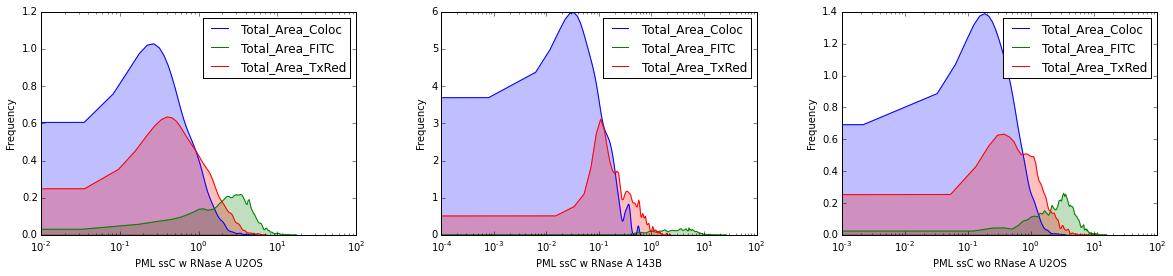

In [66]:
interact(compare_parameter_dists,
         df = fixed(raw_cell_data),
         conditions = widgets.SelectMultiple(options = raw_cell_data.Condition.unique().tolist(),height = 300),
         parameters = widgets.SelectMultiple(options = get_params(raw_cell_data),height = 300),
         bandwidth = (0,0.2,0.01),
         scale = widgets.ToggleButtons(options=['linear','log']));